In [90]:
import pandas as pd
import numpy as np
from tasks.pipeline import indicator_pipeline

from index.IndexComputation.GreenGrowthIndex import GreenGrowthScaler
from index.utils import ISO_to_Country, ISO_to_Everything

In [189]:
indicator_pipeline('ME3')

Downloading..
Preprocessing...
PreProcessing ME3 Manual files: Saving at data/indicator/ME3/preprocessed/ME3_origin.M.csv
Done
PreProcessing data/indicator/ME3/raw/ME3.1_SDG.csv: Error:  Expecting value: line 1 column 1 (char 0)
Processing...
Processing ME3: 
	 Processing ME3_origin.M.csv
	 Imputation:DONE
	 Outlier removal:DONE
	 Formatting:DONE
	 saving at data/indicator/ME3/processed/ME3_origin.M.csv


In [185]:
from processing.utils import add_ISO


def preprocess_loss():
    df = (
        pd.read_csv('data/indicator/ME3/raw/ME3_FAO.M.csv')
          .groupby(['Area', 'Year', 'Element'])['Value'].sum().reset_index()
          .pivot(index=['Area', 'Year'], columns='Element', values='Value')
    )
    
    df['Value'] = df['Loss'] / df['Production'] * 100
    df = df['Value'].reset_index().rename(columns={'Area': 'Country'})
    
    df = add_ISO(df)
    return df


def preprocess_waste():
    cons = (
        pd.read_csv('data/indicator/ME3/raw/ME3.0_FAO.M.csv')
          .groupby(['Area', 'Year'])['Value']
          .sum().to_frame(name='Value')     
          .reset_index()
          .rename(columns={'Area': 'Country'})
    )
    cons = add_ISO(cons)
    
    waste = (
        pd.read_csv('data/indicator/ME3/raw/ME3.1_SDG.csv').groupby(['GeoAreaName', 'TimePeriod'])['Value']
          .sum().reset_index()
          .rename(columns={'GeoAreaName': 'Country', 'TimePeriod': 'Year'})
          .drop(columns=['Year'])
    
    )
    waste = add_ISO(waste)
    
    df = pd.merge(cons, waste, on=['ISO'], suffixes=('_cons', '_waste'))
    
    df['Value'] = df['Value_waste'] / df['Value_cons'] * 100
    return df[['ISO', 'Year', 'Value']]


def preprocess():
    df_waste = preprocess_waste()
    df_loss = preprocess_loss()
    
    df = df_loss.merge(df_waste, on=['ISO', 'Year'], suffixes=('_loss_to_production', '_waste_to_consumption'))
    
    df['Value'] = df[['Value_loss_to_production', 'Value_waste_to_consumption']].mean(axis=1)
    
    
    #ST = pd.DataFrame({"Indicator": ['ME3'], "Number of targets": 1, "Relation": 'negative', 'Target 1': 0, 'Target 2': np.nan}).set_index('Indicator')
    #df.rename(columns={"Value": 'ME3'}).groupby(['Year']).apply(lambda x: GreenGrowthScaler().normalize(x[['ME3', 'ISO']], ST)).reset_index().drop(columns=['level_1']).rename(columns='')
    
    return df[['ISO', 'Year', 'Value']]
    

In [186]:
df = preprocess()

In [187]:
#Normalized_Indicator = GreenGrowthScaler().normalize(indicator, ST)
df

,ISO,Year,Value
0,AFG,2014,25.377893
1,AFG,2015,24.706212
2,AFG,2016,23.076428
3,AFG,2017,23.270161
4,AFG,2018,23.739682
...,...,...,...
870,ZWE,2014,28.316810
871,ZWE,2015,29.498074
872,ZWE,2016,29.570622
873,ZWE,2017,29.767128


,Year,ME3,ISO
0,2014,27.063486,AFG
1,2014,71.902978,ALB
2,2014,56.060902,DZA
3,2014,35.664025,AGO
4,2014,56.165306,ATG
...,...,...,...
870,2018,48.767895,VEN
871,2018,62.043387,VNM
872,2018,11.065377,YEM
873,2018,36.453602,ZMB


In [159]:
ST

,Number of targets,Relation,Target 1,Target 2
Indicator,,,,
ME3,1,negative,0,NaN


In [156]:
df = preprocess()

<AxesSubplot:>

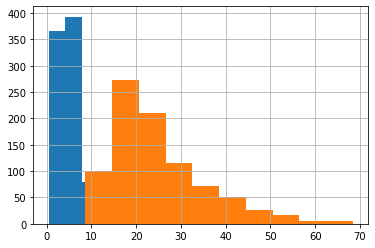

In [131]:
df_waste = preprocess_waste()
df_loss = preprocess_loss()

In [132]:
df_loss

,Country,ISO,Year,Value
0,Afghanistan,AFG,2014,7.173259
1,Afghanistan,AFG,2015,6.810589
2,Afghanistan,AFG,2016,7.301008
3,Afghanistan,AFG,2017,6.726861
4,Afghanistan,AFG,2018,6.114663
...,...,...,...,...
870,Zimbabwe,ZWE,2014,3.866814
871,Zimbabwe,ZWE,2015,4.149432
872,Zimbabwe,ZWE,2016,4.217453
873,Zimbabwe,ZWE,2017,5.564645


In [123]:
df_loss.merge(df_waste, on=['ISO', 'Year'], suffixes=('_loss_to_production', '_waste_to_consumption')).to_csv('food_waste_loss.csv')

In [86]:
test = df.sort_values(by=['Value'], ascending=False).query('Year == 2018').head(50)[['ISO', 'Year', 'Value']]

In [94]:
ISO_to_Everything(df).sort_values(by=['Value'], ascending=False).query('Year == 2018').head(50)[['Country', 'Year', 'Value']]

,Country,Year,Value
ISO,,,
MYS,Malaysia,2018.0,65.412438
YEM,Yemen,2018.0,55.089779
TCD,Chad,2018.0,54.132038
ZWE,Zimbabwe,2018.0,53.236745
MOZ,Mozambique,2018.0,50.333901
GMB,Gambia,2018.0,48.941683
NGA,Nigeria,2018.0,46.410052
IRQ,Iraq,2018.0,45.465969
MDG,Madagascar,2018.0,45.131292


In [130]:
pd.read_csv('data/indicator/ME3/raw/ME3.1_SDG.csv').query('GeoAreaName == "Australia"')

,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,TimeCoverage,UpperBound,LowerBound,BasePeriod,Source,GeoInfoUrl,FootNote,Food Waste Sector,Nature,Observation Status,Reporting Type,Units
75,AG_FOOD_WST,Food waste (Tonnes),36,Australia,2019,2.563110e+06,2019,NaN,NaN,NaN,NaN,Food Waste Index Report 2021 / WESR,NaN,High Confidence,HHS,E,A,G,TONNES
76,AG_FOOD_WST,Food waste (Tonnes),36,Australia,2019,5.463396e+05,2019,NaN,NaN,NaN,NaN,Food Waste Index Report 2021 / WESR,NaN,High Confidence,OOHC,E,A,G,TONNES
77,AG_FOOD_WST,Food waste (Tonnes),36,Australia,2019,2.382477e+05,2019,NaN,NaN,NaN,NaN,Food Waste Index Report 2021 / WESR,NaN,High Confidence,RTL,E,A,G,TONNES


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess():
    df = (
        pd.read_excel('data/indicator/GV2/raw/GV2_IRENA.M.xlsx')
          #.rename(columns={'ISO-code': 'ISO'})
          #.groupby(['ISO', 'Year'])['Amount (2019 USD million)'].sum()
    )
    return df#.to_frame('Value').reset_index()
df = preprocess()

In [35]:
df#.query('ISO == "FRA"')

,ISO-code,Country/Area,Region,Project,Donor,Agency,Year,Category,Technology,Sub-technology,Finance Group,Finance Type,Source,Reference Date,Amount (2019 USD million)
0,DZA,Algeria,Africa,NaN,Japan,Japanese International Co-operation Agency,2019,Renewables,Multiple renewables,Multiple renewables,Grants,Standard grant,2019 OECD Credit Report System (CRS) Database,2019-12-31 00:00:00,0.016066
1,DZA,Algeria,Africa,P209 - SCAC - Algérie - Projet - Crédits d'int...,France,Ministry of Foreign Affairs,2019,Renewables,Solar energy,On-grid Solar photovoltaic,Grants,Standard grant,2019 OECD Credit Report System (CRS) Database,2019-01-01 00:00:00,0.015672
2,DZA,Algeria,Africa,P209 - SCAC - Algérie - Projet - Crédits d'int...,France,Ministry of Foreign Affairs,2019,Renewables,Solar energy,On-grid Solar photovoltaic,Grants,Standard grant,2019 OECD Credit Report System (CRS) Database,2019-01-01 00:00:00,0.015672
3,DZA,Algeria,Africa,P209 - SCAC - Algérie - Projet - Crédits d'int...,France,Ministry of Foreign Affairs,2019,Renewables,Solar energy,On-grid Solar photovoltaic,Grants,Standard grant,2019 OECD Credit Report System (CRS) Database,2019-01-01 00:00:00,0.001791
4,DZA,Algeria,Africa,TC AGGREGATED ACTIVITIES,Japan,Japanese International Co-operation Agency,2013,Renewables,Multiple renewables,Multiple renewables,Grants,Standard grant,2013 OECD Credit Report System (CRS) Database,2013-01-01 00:00:00,0.928327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15922,VEN,Venezuela,South America,Climate Change Workshop,United Kingdom,Foreign & Commonwealth Office,2014,Renewables,Multiple renewables,Multiple renewables,Grants,Standard grant,2014 OECD Credit Report System (CRS) Database,2014-01-01 00:00:00,0.002444
15923,VEN,Venezuela,South America,Rehabilitation of Units 1 to 6 of Powerhouse I...,Inter-American Development Bank,Ordinary Capital,2010,Renewables,Renewable hydropower,Renewable hydropower,Debt,Standard loan,2010 OECD Credit Report System (CRS) Database,2010-10-27 00:00:00,685.681463
15924,VEN,Venezuela,South America,"A Powerhouse 1 Central Simon Bolivar"" Project",Inter-American Development Bank,Inter-American Development Bank,2015,Renewables,Renewable hydropower,Renewable hydropower,Grants,Standard grant,https://www.iadb.org/project/VE-T1050,42275,0.351932
15925,VEN,Venezuela,South America,Support to the Implementation of the Guri Reha...,Inter-American Development Bank,Inter-American Development Bank,2018,Renewables,Renewable hydropower,Renewable hydropower,Grants,Standard grant,https://www.iadb.org/project/VE-T1064,43423,0.392393


# Food security

In [ ]:
indicator_pipeline('GS1')

In [ ]:
data = pd.read_csv('data/indicator/GS1/processed/GS1_SDG.csv')
ST = pd.DataFrame({"Indicator": ['GS1'], "Number of targets": 1, "Relation": 'negative', 'Target 1': 0, 'Target 2': np.nan}).set_index('Indicator')
df = (
    data.groupby('Year')
        .apply(lambda x: GreenGrowthScaler().normalize(x.rename(columns={'Value': 'GS1'}).set_index('ISO')[['GS1']], ST)).reset_index()
        .pivot(index=['ISO'], columns=['Year'], values='GS1')
        .dropna(axis=1, how='all')
        .reset_index()
)
#ISO_to_Everything(df)#.to_csv('data/indicator/GS1/processed/food_insecurity_ts.csv')

In [ ]:
# # This part is added to data/indicator/TMP/preprocess.py

# def process_TMP():
#     df = (
#         pd.read_csv('data/indicator/TMP/raw/TMP_IEA.M.csv')
#           .melt(id_vars=['Country', 'Mode/vehicle type', 'Indicator'], var_name=['Year'], value_name='Value')
#           .rename(columns={'Mode/vehicle type': 'mode'})
#           .assign(Indicator=lambda x: x.Indicator.str.strip())
#           .query("mode == 'Total passenger transport' and Indicator == 'Passenger-kilometres energy intensity (MJ/pkm)'")
#           .drop(columns=['mode', 'Indicator'])
#           .dropna()
#     )
#     return df
    
    
# config_TMP = {'Variable': 'TMP',
#              'function': process_TMP,
#              'Description': 'Total passenger transport Passenger-kilometres energy intensity (MJ/pkm)',
#              'Source': 'IEA',
#              'URL': 'https://www.iea.org/data-and-statistics/data-product/energy-efficiency-indicators'}

In [ ]:
from index.IndexComputation.GreenGrowthIndex import GreenGrowthScaler

indicator = (pd.read_csv('data/indicator/TMP/processed/TMP_origin.M.csv')
               .query("Year == 2019")
               .set_index("ISO")[['Value']]
                .rename(columns={"Value": 'TMP'})
            ) # Data Frame with indicators here there is just "TMP", must be for a single year ! 

ST = pd.DataFrame({"Indicator": ['TMP'], "Number of targets": 1, "Relation": 'negative', 'Target 1': 1.104, 'Target 2': np.nan}).set_index('Indicator')
Normalized_Indicator = GreenGrowthScaler().normalize(indicator, ST) # Call this and that's it.

# ST stands for sustainable target:
# - Number of targets is almost always 1 so leave it as 1 by default
# - Relation is wether high value is good/bad for the environnment. Here, lower energy intensity is better so the relation is negative
# - Target 1 and 2 are for the value of the target. To compute the target take the average of the 5 best countries

In [ ]:
Normalized_Indicator = GreenGrowthScaler().normalize(indicator, ST) # Call this and that's it.
Normalized_Indicator

In [ ]:
Normalized_Indicator.to_csv('data/indicator/TMP/processed/TMP_Normalized_origin.M.csv') # You can share this

In [ ]:
pd.read_csv('data/sustainable_targets/ST_2020.csv', index_col=0) # Just so you can see what it looks like for other indicators

#  Universal acess

In [ ]:
import pandas as pd
import numpy as np
from index.IndexComputation.GreenGrowthIndex import GreenGrowthScaler
from sklearn.preprocessing import MinMaxScaler

def process():
    df_1 = pd.read_csv('data/indicator/GS3/raw/Rural access index.csv').dropna(axis=1).rename(columns={'Value': 'Rural access index'})
    df_2 = pd.read_csv('data/indicator/GS3/raw/Percentage of female workers in transport.csv').dropna(axis=1).rename(columns={'Value': 'Percentage female workers in transport'})
    df_3 = pd.read_csv('data/indicator/GS3/raw/Rapid Transit to Resident Ratio.csv').dropna(axis=1).rename(columns={'Value': 'Rapid Transit to Resident Ratio'})

    
    df = pd.concat([df_1.set_index(['Country']), df_2.set_index(['Country']), df_3.set_index(['Country'])], axis=1).drop(columns=['Year']).dropna()

    
    df_norm = pd.DataFrame(MinMaxScaler(feature_range=(1, 100)).fit_transform(df), columns=df.columns, index=df.index)
    return df_norm.mean(axis=1).to_frame(name='Value').assign(Year=2020).reset_index()

In [ ]:
df = process()
#df = add_ISO(df.reset_index())
#ISO_to_Everything(df)[['Country', 'Universal Acess']].to_csv('data/indicator/GS3/processed/normalized_universal_access_index.csv')

In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np
from index.IndexComputation.GreenGrowthIndex import GreenGrowthScaler
from sklearn.preprocessing import MinMaxScaler
from processing.utils import add_ISO
from index.utils import ISO_to_Everything

def process():
    df = pd.read_csv('data/indicator/GS3/raw/Logistics performance index.csv').dropna(axis=1).rename(columns={'Value': 'Logistics performance index'}).set_index('Country')

    
    
    
    ST = pd.DataFrame({"Indicator": ['Logistics performance index'],
                   "Number of targets": [1],
                   "Relation": ['positive'],
                   'Target 1': [4.069],
                   'Target 2': [np.nan]}).set_index('Indicator')

    #df_norm = GreenGrowthScaler().normalize(df[['Logistics performance index']], ST) # Call this and that's it.
    df_norm = pd.DataFrame(MinMaxScaler(feature_range=(1, 100)).fit_transform(df), columns=df.columns, index=df.index)

    return df_norm

In [ ]:
df = process()
df = add_ISO(df['Logistics performance index'].reset_index())

In [ ]:
ISO_to_Everything(df)[['Country', 'Logistics performance index']].to_csv('data/indicator/GS3/processed/normalized_Logistics_performance_index.csv')

In [ ]:
pd.read_csv('data/indicator/GS3/processed/normalized_Logistics_performance_index.csv')

In [ ]:
pd.read_csv('data/indicator/GS3/processed/normalized_universal_access_index.csv')